# Laboratorio 9

In [2]:
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt

from vega_datasets import data

alt.themes.enable('opaque')
%matplotlib inline

En este laboratorio utilizaremos un conjunto de datos _famoso_, el GapMinder. Esta es una versión reducida que solo considera países, ingresos, salud y población. 

¿Hay alguna forma natural de agrupar a estos países?

In [3]:
gapminder = data.gapminder_health_income()
gapminder.head()

,country,income,health,population
0,Afghanistan,1925,57.63,32526562
1,Albania,10620,76.00,2896679
2,Algeria,13434,76.50,39666519
3,Andorra,46577,84.10,70473
4,Angola,7615,61.00,25021974


## Ejercicio 1

(1 pto.)

Realiza un Análisis exploratorio, como mínimo un `describe` del dataframe y una visualización adecuada, por ejemplo un _scatter matrix_ con los valores numéricos.

In [4]:
gapminder.describe()

,income,health,population
count,187.000000,187.000000,1.870000e+02
mean,17232.240642,71.673262,3.908887e+07
std,19310.632882,7.748959,1.432898e+08
min,599.000000,48.500000,5.299300e+04
25%,3585.500000,65.500000,2.248920e+06
50%,10996.000000,73.130000,8.544586e+06
75%,23834.000000,77.700000,2.769388e+07
max,132877.000000,84.100000,1.376049e+09


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FEF9C46E48>,
      dtype=object)

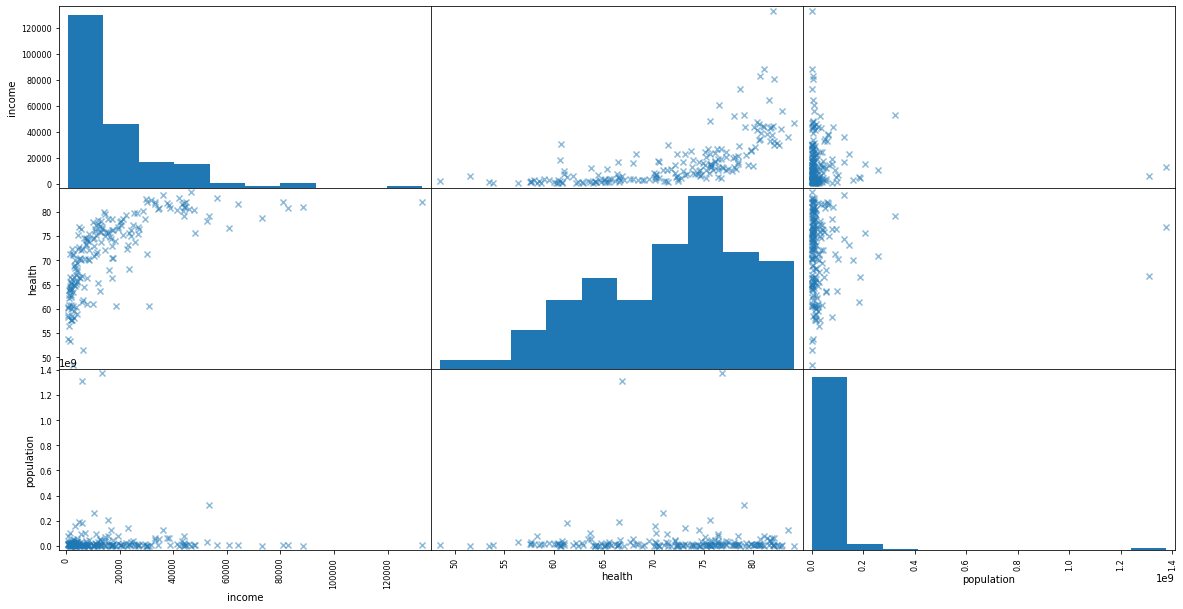

In [5]:
pd.plotting.scatter_matrix(gapminder, figsize=(20,10), marker="x")

In [37]:
alt.Chart(gapminder).mark_circle(opacity=0.5).encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
    color='species:N'
).properties(
    width=150,
    height=150
).repeat(
    row=['income', 'health', 'population'],
    column=['income', 'health', 'population']
)

alt.RepeatChart(...)

__Pregunta:__ ¿Hay alguna variable que te entregue indicios a simple vista donde se puedan separar países en grupos?

__Respuesta:__ No existe ninguna separación clara, aunque se ven un par de casos muy aislados los cuales podrían ser considerados como un grupo (países con mucha población).

## Ejercicio 2

(1 pto.)

Aplicar un escalamiento a los datos antes de aplicar nuestro algoritmo de clustering. Para ello, definir la variable `X_raw` que corresponde a un `numpy.array` con los valores del dataframe `gapminder` en las columnas _income_, _health_ y  _population_. Luego, definir la variable `X` que deben ser los datos escalados de `X_raw`.

In [7]:
from sklearn.preprocessing import StandardScaler

In [30]:
X_raw = gapminder[['income', 'health', 'population']].to_numpy()
scaler = StandardScaler()
X = scaler.fit(X_raw)
X = scaler.transform(X_raw)

In [31]:
X

array([[-7.94812582e-01, -1.81714240e+00, -4.59203854e-02],
       [-3.43333732e-01,  5.59862729e-01, -2.53258375e-01],
       [-1.97219703e-01,  6.24560745e-01,  4.04215845e-03],
       [ 1.52369617e+00,  1.60797060e+00, -2.73035026e-01],
       [-4.99365238e-01, -1.38107777e+00, -9.84344701e-02],
       [ 1.98181268e-01,  4.56345903e-01, -2.72885662e-01],
       [ 5.80298868e-03,  5.85741936e-01,  3.02847998e-02],
       [-4.91680492e-01,  3.52829076e-01, -2.52411434e-01],
       [ 1.39279586e+00,  1.31035972e+00, -1.05802947e-01],
       [ 1.41070963e+00,  1.20684289e+00, -2.13736596e-01],
       [-1.27857897e-02,  1.58735027e-01, -2.05273828e-01],
       [ 2.90034757e-01,  8.10974068e-02, -2.70812967e-01],
       [ 1.39705363e+00,  9.73930035e-01, -2.63890818e-01],
       [-7.30634565e-01, -2.03573866e-01,  8.53054502e-01],
       [-2.20585486e-01,  5.33983522e-01, -2.71539346e-01],
       [ 9.48958998e-03, -1.64755056e-01, -2.07080201e-01],
       [ 1.24657799e+00,  1.12920527e+00

## Ejercicio 3

(1 pto.)

Definir un _estimator_ `KMeans` con `k=3` y `random_state=42`, luego ajustar con `X` y finalmente, agregar los _labels_ obtenidos a una nueva columna del dataframe `gapminder` llamada `cluster`. Finalmente, realizar el mismo gráfico del principio pero coloreado por los clusters obtenidos.


In [32]:
from sklearn.cluster import KMeans

In [39]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X)
clusters = kmeans.labels_
gapminder["cluster"] = clusters

In [41]:
alt.Chart(gapminder).mark_circle(opacity=0.5).encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
    color='cluster:N'
).properties(
    width=150,
    height=150
).repeat(
    row=['income', 'health', 'population'],
    column=['income', 'health', 'population']
)

alt.RepeatChart(...)

## Ejercicio 4

(1 pto.)

__Regla del codo__

__¿Cómo escoger la mejor cantidad de _clusters_?__

En este ejercicio hemos utilizado que el número de clusters es igual a 3. El ajuste del modelo siempre será mejor al aumentar el número de clusters, pero ello no significa que el número de clusters sea el apropiado. De hecho, si tenemos que ajustar $n$ puntos, claramente tomar $n$ clusters generaría un ajuste perfecto, pero no permitiría representar si existen realmente agrupaciones de datos.

Cuando no se conoce el número de clusters a priori, se utiliza la [regla del codo](https://jarroba.com/seleccion-del-numero-optimo-clusters/), que indica que el número más apropiado es aquel donde "cambia la pendiente" de decrecimiento de la la suma de las distancias a los clusters para cada punto, en función del número de clusters.

A continuación se provee el código para el caso de clustering sobre los datos estandarizados, leídos directamente de un archivo preparado especialmente.En la línea que se declara `kmeans` dentro del ciclo _for_ debes definir un estimador K-Means, con `k` clusters y `random_state` 42. Recuerda aprovechar de ajustar el modelo en una sola línea.

In [44]:
elbow = pd.Series(name="inertia", dtype="float64").rename_axis(index="k")
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
    elbow.loc[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
elbow = elbow.reset_index()

In [45]:
alt.Chart(elbow).mark_line(point=True).encode(
    x="k:O",
    y="inertia:Q"
).properties(
    height=600,
    width=800
)

alt.Chart(...)

__Pregunta:__ Considerando los datos (países) y el gráfico anterior, ¿Cuántos clusters escogerías?

__Respuesta:__ A partir de la regla del codo, elegiría 4 clusters.